In [131]:
#Main packages
from ddeint import ddeint
from soad import AsymmetricData as asyd
import pymultinest
from pymultinest.solve import Solver

from math import cos, isnan
from numpy import linspace,sqrt,pi,array,warnings,VisibleDeprecationWarning,diff,linalg,inf,diag,round,log,log10,vstack,savetxt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import MatplotlibDeprecationWarning
from scipy.integrate import odeint, quad
from scipy import interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.constants import c
from getdist import MCSamples
import getdist.plots as gdplt
import pandas as pd
from time import time
import corner

In [129]:
warnings.filterwarnings('ignore', category=VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning) 

# 0. Definition of functions

In [11]:
OmegaLambda = 1e-6

def basic(y,t,r,d,w):
    x = y(t)
    xd = y(t-d)
    
    return x*sqrt(r/3)*sqrt(1/(xd**(3*(1+w))))

def basic_history(t):
    
    return (t + 1e-32)**alpha

#Background expansion a(t) equation incorporating matter and dark energy densities
def background(y,t,d,w):
    
    #y = solution
    #t = time
    #d = delay
    #w = equation of state parameter
        
    x = y(t)
    xd = y(t-d)
    
    return x*sqrt((1-OmegaLambda)/(xd**(3*(1+w)))+OmegaLambda)

#Derivative of background expansion incorporating matter and dark energy densities
def background_derivative(a,t,d,w):
    
    #t = time
    #t_i = starting integation time
    #d = delay
    #w = equation of state parameter
    #a_background(t) = interpolation of matter solution
    
    derivative = []
    
    for time in t:
        
        if time <= t_i+d:
            if (1-OmegaLambda)/(history(time-d)**(3*(1+w)))+OmegaLambda < 0:
                print("Time: ", time)
                print("Delay: ", d)
                print("History(t-d): ", history(time-d))
            derivative.append(a(time)*sqrt((1-OmegaLambda)/(history(time-d)**(3*(1+w)))+OmegaLambda))
        else:
            derivative.append(a(time)*sqrt((1-OmegaLambda)/(a(time-d)**(3*(1+w)))+OmegaLambda))
    
    return derivative

#Matter density evolution equation
def matter(y,t,d,w):
    
    #y = solution
    #t = time
    #d = delay
    #w = equation of state parameter
    
    x = y(t)
    xd = y(t-d)
    
    return x*sqrt(1/(xd**(3*(1+w))))

#Derivative of matter density evolution
def matter_derivative(a,t,d,w): 
    
    #t = time
    #t_i = starting integation time
    #d = delay
    #w = equation of state parameter
    #a(t) = interpolation of matter solution
    
    derivative = []
    
    for time in t:
        
        if time <= t_i+d:
            derivative.append(a(time)*sqrt(1/(history(time-d)**(3*(1+w)))))
        else:
            derivative.append(a(time)*sqrt(1/(a(time-d)**(3*(1+w)))))
    
    return derivative


#The initial history for the DDE
def history(t):
        
    c = t_i**(2/3) - (t_i+1e-32)**alpha #ensures that initial history equals to t_i^{2/3} at t = t_i
    
    return (t+1e-32)**alpha + c 


#The background Hubble expansion
def hubble_background(a,t,d,w):
    
    #t = time
    #d = delay
    #w = equation of state parameter
    #a_background(t) = interpolation of matter solution
    
    return background_derivative(a,[t],d,w)/a(t)

#The background matter density evolution
def hubble_matter(a,t,d,w):
    
    #t = time
    #d = delay
    #w = equation of state parameter
    #a(t) = interpolation of matter solution
    
    return matter_derivative(a,[t],d,w)/a(t)

#The perturbation equation for the overdensity
def perturbation(y,t,am,ab,d,w):
    
    #p = delta(t)
    #q = delta'(t)
    
    p,q = y
    dydt = [q, (3/2)*hubble_matter(am,t,d,w)**2*p-2*hubble_background(ab,t,d,w)*q]
    return dydt

In [32]:
#Function to calculate apparent magnitude
def appmag_func(tt, tau, power, eos, H0):
    global t_i, alpha 
    t_i = tt[0]
    alpha = power
    
    #The background solution
    bb = ddeint(background, history, tt, fargs = (tau,eos))
    a_background = UnivariateSpline(tt, bb, k=3, s=0)
    a_prime = background_derivative(a_background,tt,tau,eos)
    a_derivative = UnivariateSpline(tt, a_prime, k=3, s=0)
    
    redshift = list(a_background(tt[-1])/a_background(tt) -1)
    redshift.reverse()
    
    hub = list((a_prime/bb)*(a_background(tt[-1])/a_derivative(tt[-1])))
    hub.reverse()
    hubz = UnivariateSpline(redshift, hub, k=3, s=0)
    
    def dl(z):
        
        def inv_hubble_func(x):
            return 1/hubz(x)
        rz = quad(inv_hubble_func, 0, z)[0]
        return (1 + z)*rz
    
    m = []
    redshift.remove(0.0)
    for z in redshift:
        m.append(5*log10((c*100/H0)*dl(z)) - 19.3)
    
    m = UnivariateSpline(redshift, m, k=3, s=0)
    
    return redshift, m
    

#Function to calculate density contrast and its derivative
def growth_func(tt, tau, power, eos):
    
    global t_i, alpha 
    t_i = tt[0]
    alpha = power
    
    #The background solution
    bb = ddeint(background, history, tt, fargs = (tau,eos))
    a_background = UnivariateSpline(tt, bb, k=3, s=0)
        
    #The matter solution
    mm = ddeint(matter, history, tt, fargs = (tau,eos))
    a_matter = UnivariateSpline(tt, mm, k=3, s=0)
        
    #The perturbation solution
    y0 = [a_background(t_i), background_derivative(a_background,[t_i],tau,eos)[0]] #initial condition
    pp = odeint(perturbation, y0, tt, args=(a_matter,a_background,tau,0)) 
    delta = UnivariateSpline(tt, pp[:,0], k=3, s=0)
    delta_prime = UnivariateSpline(tt, pp[:,1], k=3, s=0)
    
    return a_background, a_matter, delta, delta_prime

In [31]:
def func_hubble(eval_points, delay, H0):
        
    global alpha
    alpha = 2/3
    global t_i
    t_i = 21
    tt = linspace(t_i,t_f,2000)
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)

    redshift = list(sol_background(tt[-1])/sol-1)
    redshift.reverse()
    
    observable = list(H0*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])))
    observable.reverse()
    

    hubz = UnivariateSpline(redshift, observable, k=3, s=0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    hubble_theo = array([hubz(z) for z in valid_z])
    
    return valid_z, hubble_theo

def func_appmag(eval_points, delay, H0):
    
    global alpha
    alpha = 2/3
    global t_i
    t_i = 21
    tt = linspace(t_i,t_f,100)
    
    redshift, m = appmag_func(tt, delay, alpha, 0, H0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    appmag_theo = m(valid_z)
    
    return  valid_z, appmag_theo

def func_background(eval_points, delay, H0):
    
    global alpha
    alpha = 2/3
    global t_i
    t_i = 21
    tt = linspace(t_i,t_f,2000)
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)

    redshift = list(sol_background(tt[-1])/sol-1)
    redshift.reverse()
    
    observable = list(H0*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])))
    observable.reverse()
    

    hubz = UnivariateSpline(redshift, observable, k=3, s=0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    hubble_theo = array([hubz(z) for z in valid_z])
    
    redshift, m = appmag_func(tt, delay, alpha, 0, H0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    appmag_theo = m(valid_z)
    
    return hubble_theo, appmag_theo

def func_f(eval_points, delay):
    
    global alpha 
    alpha = 2/3
    global t_i 
    t_i = 21
    tt = linspace(t_i,t_f,2000)
    
    a_b, a_m, d, d_p = growth_func(tt, delay, alpha, 0)
    
    redshift = list(a_b(tt[-1])/a_b(tt) -1)
    redshift.reverse()
    
    observable = list((d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)))
    observable.reverse()
    fz = UnivariateSpline(redshift, observable, k=3, s=0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    f_theo = array([fz(z) for z in valid_z])
        
    return valid_z, f_theo

def func_fsigma8(eval_points, delay, sigma_8):
    
    global alpha 
    alpha = 2/3
    global t_i 
    t_i = 21
    tt = linspace(t_i,t_f, 2000)
    
    a_b, a_m, d, d_p = growth_func(tt, delay, alpha, 0)
    
    redshift = list(a_b(tt[-1])/a_b(tt) -1)
    redshift.reverse()
    
    observable = list((sigma_8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)))
    observable.reverse()
    fsigma8z = UnivariateSpline(redshift, observable, k=3, s=0)
    
    valid_z = eval_points[eval_points <= max(redshift)]
    fsigma8_theo = array([fsigma8z(z) for z in valid_z])
    
    return valid_z, fsigma8_theo

def func_perturbation(eval_points, delay, sigma_8):
    
    global alpha 
    alpha = 2/3
    global t_i 
    t_i = 21
    tt = linspace(t_i,t_f, 2000)
    
    a_b, a_m, d, d_p = growth_func(tt, delay, alpha, 0)
    
    redshift = list(a_b(tt[-1])/a_b(tt) -1)
    redshift.reverse()
    
    observable = list((d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)))
    observable.reverse()
    fz = UnivariateSpline(redshift, observable, k=3, s=0)
    f_theo = array([fz(z) for z in eval_points[0]])
        
    observable = list((sigma_8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)))
    observable.reverse()
    fsigma8z = UnivariateSpline(redshift, observable, k=3, s=0)
    fsigma8_theo = array([fsigma8z(z) for z in eval_points[1]])
    
    return f_theo, fsigma8_theo

def func_all(eval_points, delay, H0, sigma_8):
    
    global alpha 
    alpha = 2/3
    global t_i 
    t_i = 21
    tt = linspace(t_i,t_f, 2000)
    
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)

    redshift = list(sol_background(tt[-1])/sol-1)
    redshift.reverse()
    
    observable = list(H0*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])))
    observable.reverse()
    
    hubz = UnivariateSpline(redshift, observable, k=3, s=0)
    
    hubble_theo = array([hubz(z) for z in eval_points[0]])
    
    a_b, a_m, d, d_p = growth_func(tt, delay, alpha, 0)
    
    redshift = list(a_b(tt[-1])/a_b(tt) -1)
    redshift.reverse()
    
    observable = list((d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)))
    observable.reverse()
    fz = UnivariateSpline(redshift, observable, k=3, s=0)
    f_theo = array([fz(z) for z in eval_points[1]])
        
    observable = list((sigma_8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)))
    observable.reverse()
    fsigma8z = UnivariateSpline(redshift, observable, k=3, s=0)
    fsigma8_theo = array([fsigma8z(z) for z in eval_points[2]])
    
    return hubble_theo, f_theo, fsigma8_theo

In [110]:
#Function to open samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
    
    if nparams == 1:
        samples = vstack((array(chains.iloc[:, 0])))
    if nparams == 2:
        samples = vstack((array(chains.iloc[:, 0]), array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = vstack((array(chains.iloc[:, 0]), array(chains.iloc[:, 1]), array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = vstack((array(chains.iloc[:, 0]), array(chains.iloc[:, 1]), array(chains.iloc[:, 2]), array(chains.iloc[:, 3]))).T
    
    return samples

#GetDist 
def gdplots(gdsamples, params, file, axes_label, axes_font):
    
    gdplot = gdplt.get_subplot_plotter(width_inch=7)
    gdplot.settings.figure_legend_frame = True
    gdplot.settings.axes_labelsize = axes_label
    gdplot.settings.axes_fontsize = axes_font
    gdplot.settings.alpha_filled_add = 0.9
    gdplot.triangle_plot(gdsamples, params,contour_colors=[((1,1,1,0),'red')],
                     filled=True,title_limit=False)
    
    if isinstance(file, str):
        gdplot.export(file)
    

def gdstats(gdsamples, params):
    
    stats = gdsamples.getMargeStats()
    
    for i in range(len(params)):
        print(params[i]+ ' mean', stats.parWithName(params[i]).mean)
        print(params[i], '68% ci', '-', stats.parWithName(params[i]).mean-stats.parWithName(params[i]).limits[0].lower, '+', stats.parWithName(params[i]).limits[0].upper-stats.parWithName(params[i]).mean)
        print(params[i], '95% ci', '-', stats.parWithName(params[i]).mean-stats.parWithName(params[i]).limits[1].lower, '+', stats.parWithName(params[i]).limits[1].upper-stats.parWithName(params[i]).mean)
        print('')

# I. Time evolution of scale factor

## Early-time evolution of scale factor (inflation)

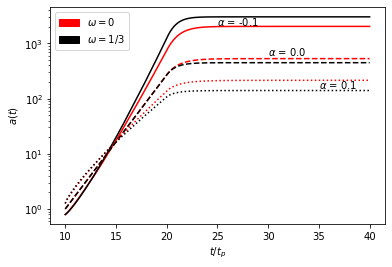

In [45]:
powers = [-0.1,0.0,0.1]
fluids = [0, 1/3]
tau = 10
rho = 1
tt = linspace(10, 40, 1000)
col = ['red', 'black']
linestyle = ['-', '--', ':']

cyan_patch = mpatches.Patch(color='red', label=r'$\omega = 0$')
black_patch = mpatches.Patch(color='black', label=r'$\omega = 1/3$')

plt.figure()
for i in range(len(powers)):
    alpha = powers[i]
    for j in range(len(fluids)):
        eos = fluids[j]
        sol = ddeint(basic, basic_history, tt, fargs = (rho,tau,eos))
        plt.semilogy(tt, sol, color = col[j], ls = linestyle[i])
        plt.legend(handles=[cyan_patch, black_patch], loc = 'best')

plt.ylabel('$a(t)$')
plt.xlabel('$t/t_p$')
plt.text(25,2.1*10**3, r'$\alpha$ = -0.1')
plt.text(30,600, r'$\alpha$ = 0.0')
plt.text(35,150, r'$\alpha$ = 0.1')
plt.savefig('inflationary_solution.pdf',bbox_inches='tight')
plt.show()

## Late-time evolution of scale factor

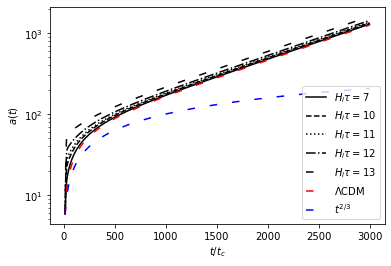

In [46]:
delays = [7,10,11,12,13]
linestyle = ['-', '--', ':','-.', (0, (5, 10))]
alpha = 2/3
t_i = 14
tt = linspace(t_i, 3*10**3,2000) 
power_law = []
for i in range(len(tt)):
    power_law.append(tt[i]**(2/3))

plt.figure()
for i in range(len(delays)):
    sol = ddeint(background, history, tt, fargs = (delays[i],0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    plt.semilogy(tt,sol, color = 'black', ls = linestyle[i], label = r'$H_i\tau = $'+str(delays[i]))

lcdm = ddeint(background, history, tt, fargs = (0,0))
lcdm_background = UnivariateSpline(tt, lcdm, k=3, s=0)

plt.semilogy(tt,lcdm, color = 'red', ls= linestyle[4], label = r'$\Lambda$CDM')
plt.semilogy(tt,power_law, color = 'blue', ls= linestyle[4], label = r'$t^{2/3}$')
plt.ylabel(r'$a(t)$')
plt.xlabel(r'$t/t_c$')
plt.legend(loc='best')
plt.savefig('cosmic_acceleration.pdf',bbox_inches='tight')
plt.show()

# II. Observational data

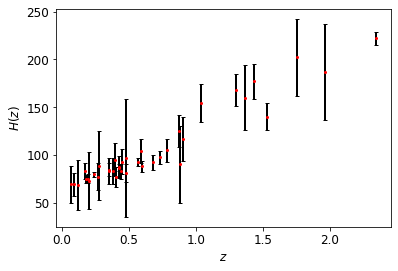

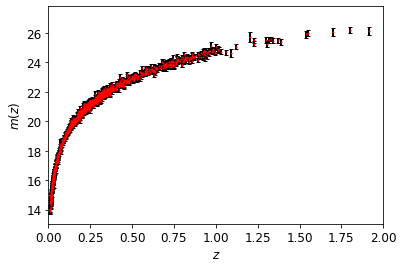

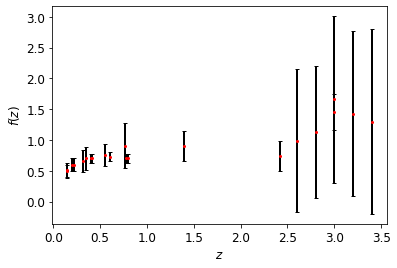

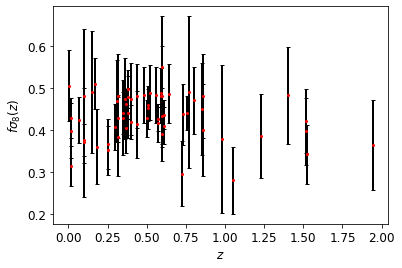

In [27]:
#Hubble expansion rate H(z) data
hubble = array(pd.read_csv('data/hubble_data.csv'))

plt.figure()
plt.errorbar(hubble[:,0], hubble[:,1], yerr=hubble[:,2], marker='.', markersize = 4, color = 'red',ecolor='black', elinewidth = 2, capsize = 2,ls='none')
plt.xlabel('$z$', fontsize='large')
plt.ylabel('$H(z)$', fontsize='large')
plt.tick_params(labelsize='large')
plt.show()

#Apparent magnitude m(z) data
appmag = array(pd.read_csv('data/appmag_data.txt', sep=" ", usecols=["zhel", "mb", "dmb"]))
appmag_sys = array(pd.read_csv('appmag_sys.txt', header = None)).flatten()
appmag_sys = appmag_sys.reshape(1048,1048)
appmag[:,2] = sqrt(diag(appmag_sys.reshape(1048,1048) + diag(appmag[:,2]**2)))
appmag = array(sorted(list(appmag), key=lambda row: row[0], reverse=False))

plt.figure()
plt.errorbar(appmag[:,0], appmag[:,1], yerr=appmag[:,2], marker='.', markersize = 2, color = 'red',ecolor='black', elinewidth = 2, capsize = 2,ls='none')
plt.xlim(0,2)
plt.xlabel('$z$', fontsize='large')
plt.ylabel('$m(z)$', fontsize='large')
plt.tick_params(labelsize='large')
plt.show()

#Growth rate f(z) data
growth_rate = array(pd.read_csv('data/growth_rate_data.csv'))
          
plt.figure()
plt.errorbar(growth_rate[:,0], growth_rate[:,1], yerr=growth_rate[:,2], marker='.', markersize = 4, color = 'red',ecolor='black', elinewidth = 2, capsize = 2,ls='none')
plt.xlabel('$z$', fontsize='large')
plt.ylabel('$f(z)$', fontsize='large')
plt.tick_params(labelsize='large')
plt.show()

#fsigma_8(z) data
fsigma8 = array(pd.read_csv('data/fsigma8_data.csv'))
    
plt.figure()
plt.errorbar(fsigma8[:,0], fsigma8[:,1], yerr=fsigma8[:,2], marker='.', markersize = 4, color = 'red',ecolor='black', elinewidth = 2, capsize = 2,ls='none')
plt.xlabel('$z$', fontsize='large')
plt.ylabel(r'$f\sigma_8(z)$', fontsize='large')
plt.tick_params(labelsize='large')
plt.show()

# III. Predictions

## Final integration time

In [33]:
#An empirical fitting of the growth rate f(z) is given by f(z) = ([Omega_m(1+z)^3]/[Omega_m(1+z)^3 + Omega_lambda])^0.55
#where Omega_m is the present-day matter density parameter value and Omega_lambda is the cosmological constant.
#We will use this empirical fitting to determine what the value of the growth rate at present is
#And consequently what the final integration time should be

#At present the value of the growth rate for Omega_m = 0.3111 and Omega_lambda = 0.6889 (Planck 2018) is 0.526123

t_i = 21 #We choose t_i = 21 because our prior for tau has maximum tau = 20
t_f = 0.9076*10**3
tt = linspace(t_i,t_f, 2000)
alpha = 2/3
a_b, a_m, d, d_p = growth_func(tt, 0, alpha, 0)
f = (d_p(tt[-1])/d(tt[-1]))/(background_derivative(a_b,[tt[-1]],0,0)/a_b([tt[-1]]))
print(f)

[0.52610945]


## Hubble dependence on $\tau$

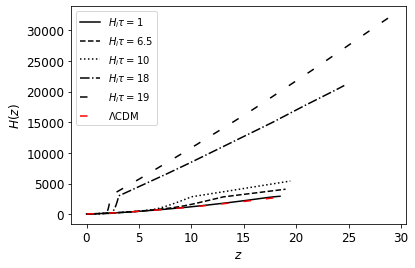

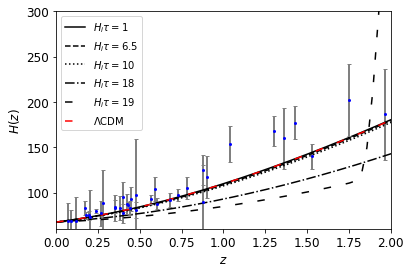

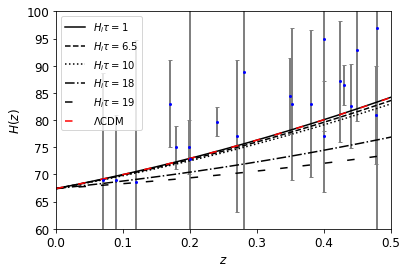

In [47]:
delays = [1,6.5,10,18,19, 0]
linestyle = ['-', '--', ':','-.', (0, (5, 10)), (0, (5, 10))]
zz = linspace(0, 35, 1000)
tt = linspace(t_i,t_f, 2000)
H0 = 67.4
x = [0,0,0,0,0,0]
y = [0,0,0,0,0,0]

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_hubble(zz, delays[i], H0)
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
    
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('hubble_vartau_full.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
        
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
    
plt.errorbar(hubble[:,0], hubble[:,1], yerr=hubble[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.xlim(0,2)
plt.ylim(60,300)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('hubble_vartau_close.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
        
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
    
plt.errorbar(hubble[:,0], hubble[:,1], yerr=hubble[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.xlim(0,0.5)
plt.ylim(60,100)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('hubble_vartau_closer.pdf',bbox_inches='tight')
plt.show()

# Hubble dependence on $\alpha$

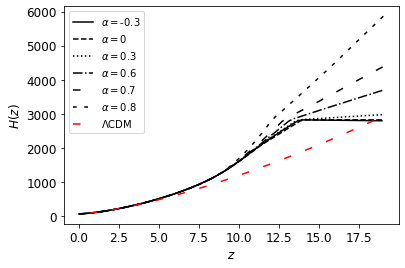

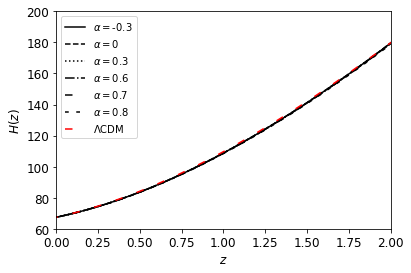

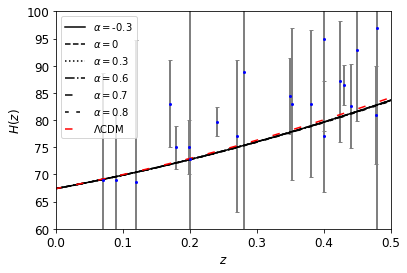

In [61]:
powers = [-0.3,0,0.3,0.6,0.7,0.8]
delay = 6.5
linestyle = ['-', '--', ':','-.', (0, (5, 10)), (0, (2.5, 5))]
t_i = 21
tt = linspace(t_i, t_f, 2000)

lcdm = ddeint(background, history, tt, fargs = (0,0))
lcdm_background = UnivariateSpline(tt, lcdm, k=3, s=0)
lcdm_prime = background_derivative(lcdm_background,tt,0,0)
lcdm_derivative = UnivariateSpline(tt, lcdm_prime, k=3, s=0)

plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)
    plt.plot(sol_background(tt[-1])/sol_background(tt)-1, 67.4*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])), color = 'black', ls = linestyle[i], label = r'$\alpha = $'+str(powers[i]))

plt.plot(lcdm_background(tt[-1])/lcdm_background(tt)-1, 67.4*(lcdm_prime/lcdm)*(lcdm_background(tt[-1])/lcdm_derivative(tt[-1])), color = 'red', ls= linestyle[4], label = r'$\Lambda$CDM')
plt.tick_params(labelsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.legend(loc='best')
plt.show()  

plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)
    plt.plot(sol_background(tt[-1])/sol_background(tt)-1, 67.4*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])), color = 'black', ls = linestyle[i], label = r'$\alpha = $'+str(powers[i]))

plt.plot(lcdm_background(tt[-1])/lcdm_background(tt)-1, 67.4*(lcdm_prime/lcdm)*(lcdm_background(tt[-1])/lcdm_derivative(tt[-1])), color = 'red', ls= linestyle[4], label = r'$\Lambda$CDM')
#plt.errorbar(hubble[:,0], hubble[:,1], yerr=hubble[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.tick_params(labelsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.legend(loc='best')
plt.xlim(0,2)
plt.ylim(60, 200)
plt.savefig('hubble_varalpha_close.pdf',bbox_inches='tight')
plt.show()  

plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    sol = ddeint(background, history, tt, fargs = (delay,0))
    sol_background = UnivariateSpline(tt, sol, k=3, s=0)
    sol_prime = background_derivative(sol_background,tt,delay,0)
    sol_derivative = UnivariateSpline(tt, sol_prime, k=3, s=0)
    plt.plot(sol_background(tt[-1])/sol_background(tt)-1, 67.4*(sol_prime/sol)*(sol_background(tt[-1])/sol_derivative(tt[-1])), color = 'black', ls = linestyle[i], label = r'$\alpha = $'+str(powers[i]))

plt.plot(lcdm_background(tt[-1])/lcdm_background(tt)-1, 67.4*(lcdm_prime/lcdm)*(lcdm_background(tt[-1])/lcdm_derivative(tt[-1])), color = 'red', ls= linestyle[4], label = r'$\Lambda$CDM')
plt.errorbar(hubble[:,0], hubble[:,1], yerr=hubble[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.tick_params(labelsize='large')
plt.ylabel(r'$H(z)$',fontsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.legend(loc='best')
plt.xlim(0,0.5)
plt.ylim(60,100)
plt.show()  

## Apparent magnitude dependence on $\tau$

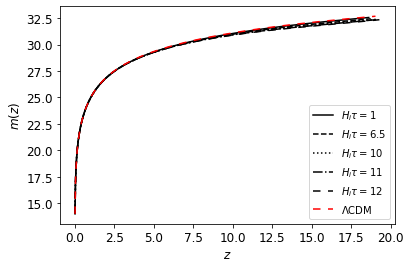

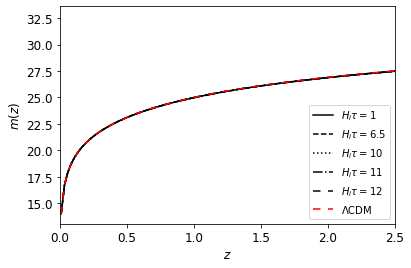

In [53]:
delays = [1,6.5,10,11,12,0]
linestyle = ['-', '--', ':','-.', (0, (5, 5)), (0, (5, 5))]
H0 = 67.4
zz = linspace(min(appmag[:,0]), 25, 1000)

x = [0,0,0,0,0,0]
y = [0,0,0,0,0,0]

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_appmag(zz, delays[i], H0)
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$m(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('appmag_vartau_full.pdf')
plt.show()

plt.figure()
#plt.errorbar(appmag[:,0], appmag[:,1], yerr=appmag[:,2], marker='.', markersize = 0.25, color = 'blue',ecolor='black', elinewidth = 0.25, capsize = 2,ls='none')
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.xlim(0,2.5)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$m(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('appmag_vartau_close.pdf')
plt.show()


## Apparent magnitude dependence on $\alpha$

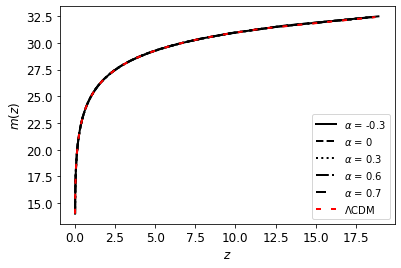

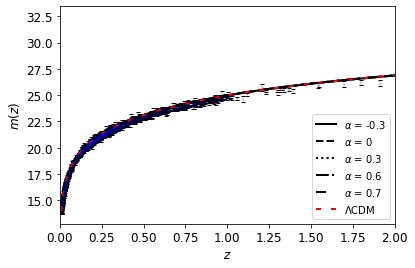

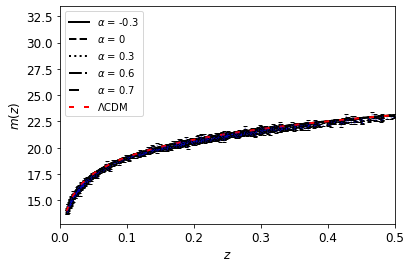

In [57]:
powers = [-0.3,0,0.3,0.6,0.7,0.8]
delay = 6.5
linestyle = ['-', '--', ':','-.', (0, (5, 10)), (0, (2.5, 5))]
t_i = 21
tt = linspace(t_i,t_f, 100)
H0 = 67.4

plt.figure()
for i in range(len(powers)):
    
    z, m = appmag_func(tt, delay, powers[i], 0, H0)
    
    if powers[i] == max(powers):
        col = 'red'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\Lambda$CDM')
    else:
        col = 'black'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
        
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$m(z)$',fontsize='large')
plt.show()

plt.figure()
plt.errorbar(appmag[:,0], appmag[:,1], yerr=appmag[:,2], marker='.', markersize = 0.25, color = 'blue',ecolor='black', elinewidth = 0.25, capsize = 2,ls='none')

for i in range(len(powers)):
    
    z, m = appmag_func(tt, delay, powers[i], 0, H0)
    
    if powers[i] == max(powers):
        col = 'red'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\Lambda$CDM')
    else:
        col = 'black'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
plt.xlim(0,2)
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$m(z)$',fontsize='large')
plt.show()

plt.figure()
plt.errorbar(appmag[:,0], appmag[:,1], yerr=appmag[:,2], marker='.', markersize = 0.25, color = 'blue',ecolor='black', elinewidth = 0.25, capsize = 2,ls='none')

for i in range(len(powers)):
    
    z, m = appmag_func(tt, delay, powers[i], 0, H0)
    
    if powers[i] == max(powers):
        col = 'red'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\Lambda$CDM')
    else:
        col = 'black'
        plt.plot(z, m(z), linewidth =2, color = col, ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
plt.xlim(0,0.5)
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$m(z)$',fontsize='large')
plt.show()

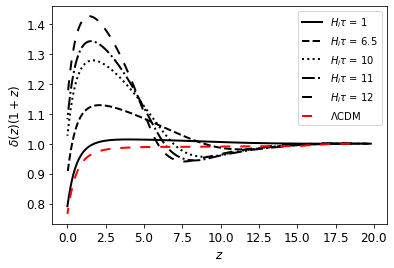

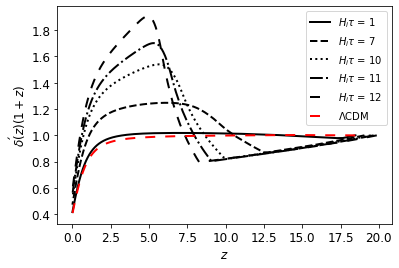

In [126]:
delays = [1,6.5,10,11,12,0]
linestyle = ['-', '--', ':','-.', (0, (5, 5)), (0, (5, 5))]
t_i = 21
tt = linspace(t_i,t_f, 2000)
alpha = 2/3

plt.figure()
for i in range(len(delays)):

    a_b, a_m, d, d_p = growth_func(tt, delays[i], alpha, 0)
    
    if delays[i] == 0:
        col = 'red'
    else:
        col = 'black'
    
    if delays[i] == 0:
        plt.plot(a_b(tt[-1])/a_b(tt) -1, d(tt)/a_b(tt), linewidth =2, color = col, ls = linestyle[i], label = r'$\Lambda$CDM')
    else:
        plt.plot(a_b(tt[-1])/a_b(tt) -1, d(tt)/a_b(tt), linewidth =2, color = col, ls = linestyle[i], label = r'$H_i\tau$ = '+str(delays[i]))
    
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel(r'$\delta(z)(1+z)$',fontsize='large')
plt.savefig('delta_over_a.pdf',bbox_inches='tight')
plt.show()  

delays = [1,7,10,11,12,0]
linestyle = ['-', '--', ':','-.', (0, (5, 5)), (0, (5, 5))]

plt.figure()
for i in range(len(delays)):
    
    a_b, a_m, d, d_p = growth_func(tt, delays[i], alpha, 0)
    
    if delays[i] == 0:
        col = 'red'
    else:
        col = 'black'
    
    if delays[i] == 0:
        plt.plot(a_b(tt[-1])/a_b(tt) -1, d_p(tt)/background_derivative(a_b,tt,delays[i],0), linewidth =2, color = col, ls = linestyle[i], label = r'$\Lambda$CDM')
    else:
        plt.plot(a_b(tt[-1])/a_b(tt) -1, d_p(tt)/background_derivative(a_b,tt,delays[i],0), linewidth =2, color = col, ls = linestyle[i], label = r'$H_i\tau$ = '+str(delays[i]))
    
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel(r'$\delta\'(z)(1+z)$',fontsize='large')
plt.savefig('dprime_over_aprime.pdf',bbox_inches='tight')
plt.show()  

## Growth rate dependence on $\tau$

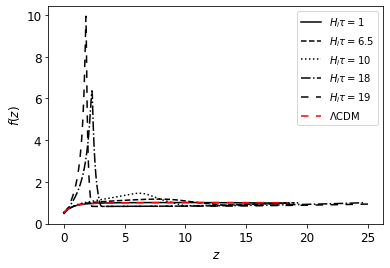

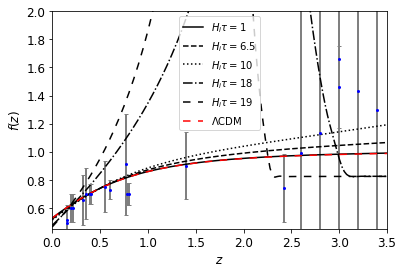

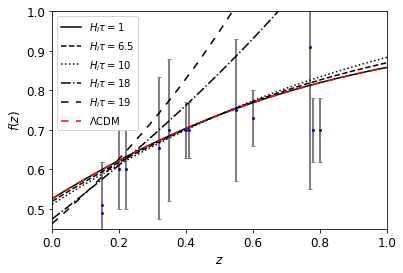

In [69]:
delays = [1,6.5,10,18,19,0]
linestyle = ['-', '--', ':','-.', (0, (5, 5)), (0, (5, 5))]
zz = linspace(0, 25, 1000)

x = [0,0,0,0,0,0]
y = [0,0,0,0,0,0]

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_f(zz, delays[i])
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f(z)$',fontsize='large')
plt.legend(loc='best')
#plt.savefig('growth_rate_vartau_full.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_f(zz, delays[i])
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.errorbar(growth_rate[:,0], growth_rate[:,1], yerr=growth_rate[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.xlim(0,3.5)
plt.ylim(0.45,2)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('growth_rate_vartau_close.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_f(zz, delays[i])
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.errorbar(growth_rate[:,0], growth_rate[:,1], yerr=growth_rate[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('growth_rate_vartau_closer.pdf',bbox_inches='tight')
plt.show()

## Growth rate dependence on $\alpha$

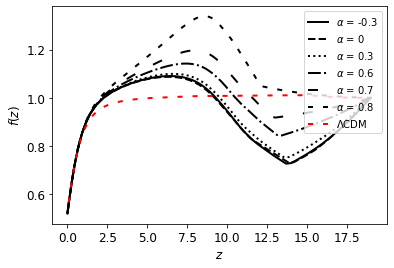

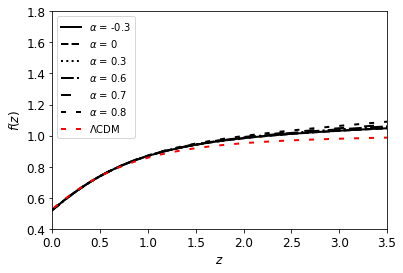

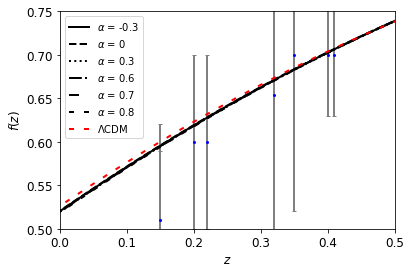

In [66]:
powers = [-0.3,0,0.3,0.6,0.7,0.8]
delay = 6.5
linestyle = ['-', '--', ':','-.', (0, (5, 10)), (0, (2.5, 5))]
t_i = 21
tt = linspace(t_i,t_f, 2000)

plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
    
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)), linewidth =2, color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, 0, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,0,0)/a_b(tt)), linewidth =2, color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f(z)$',fontsize='large')
plt.show()  

#Intermediate redshifts
plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
    
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)), linewidth =2, color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, 0, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,0,0)/a_b(tt)), linewidth =2, color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

#plt.errorbar(growth_rate[:,0], growth_rate[:,1], yerr=growth_rate[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')  
plt.tick_params(labelsize='large')
plt.xlim(0,3.5)
plt.ylim(0.4,1.8)
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f(z)$',fontsize='large')
plt.savefig('growth_rate_varalpha_close.pdf',bbox_inches='tight')
plt.show()  

#Small redshifts
plt.figure()
for i in range(len(powers)):
    
    alpha = powers[i]
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
    
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,delay,0)/a_b(tt)), linewidth =2, color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, 0, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (d_p(tt)/d(tt))/(background_derivative(a_b,tt,0,0)/a_b(tt)), linewidth =2, color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

plt.errorbar(growth_rate[:,0], growth_rate[:,1], yerr=growth_rate[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')          
plt.tick_params(labelsize='large')
plt.xlim(0,0.5)
plt.ylim(0.5,0.75)
plt.legend(loc='best')
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f(z)$',fontsize='large')
plt.show()  

## $f\sigma_8$ dependence on $\tau$

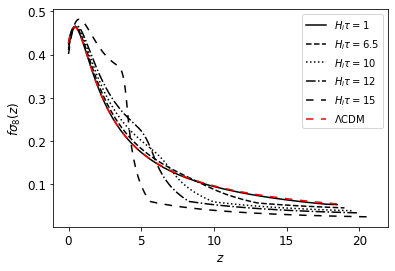

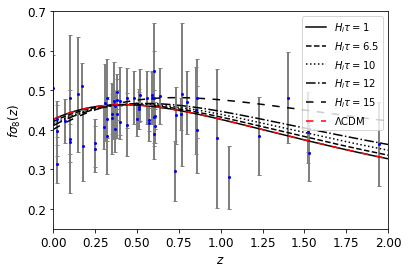

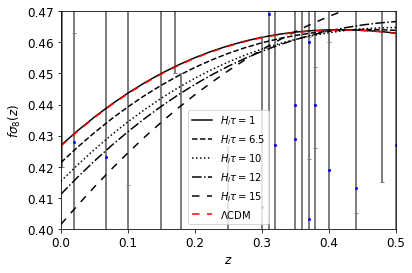

In [125]:
delays = [1,6.5,10,12,15,0]
linestyle = ['-', '--', ':','-.', (0, (5, 5)), (0, (5, 5))]
zz = linspace(0, 25, 1000)
sigma8 = 0.811

x = [0,0,0,0,0,0]
y = [0,0,0,0,0,0]

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    x[i], y[i] = func_fsigma8(zz, delays[i], sigma8)
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f\sigma_8(z)$',fontsize='large')
plt.legend(loc='best')
plt.savefig('fsigma8_vartau_full.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.errorbar(fsigma8[:,0], fsigma8[:,1], yerr=fsigma8[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')
plt.xlim(0,2)
plt.ylim(0.15,0.7)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f\sigma_8(z)$',fontsize='large')
plt.legend(loc='best')
#plt.savefig('fsigma8_vartau_close.pdf',bbox_inches='tight')
plt.show()

plt.figure()
for i in range(len(delays)):
    
    if delays[i] == 0:
        col = 'red'
        lab = r'$\Lambda$CDM'
    else:
        col = 'black'
        lab = r'$H_i\tau = $'+str(delays[i])
    
    plt.plot(x[i], y[i], color = col, ls = linestyle[i], label = lab)
plt.errorbar(fsigma8[:,0], fsigma8[:,1], yerr=fsigma8[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')
plt.xlim(0.0,0.5)
plt.ylim(0.4,0.47)
plt.tick_params(labelsize='large')
plt.xlabel(r'$z$',fontsize='large')
plt.ylabel(r'$f\sigma_8(z)$',fontsize='large')
plt.legend(loc='best')
#plt.savefig('fsigma8_vartau_closer.pdf',bbox_inches='tight')
plt.show()

## $f\sigma_8$ dependence on $\alpha$

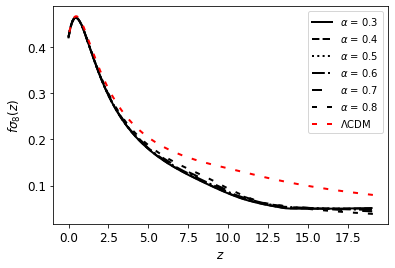

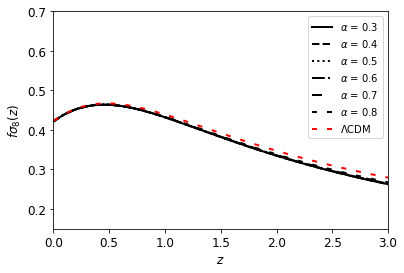

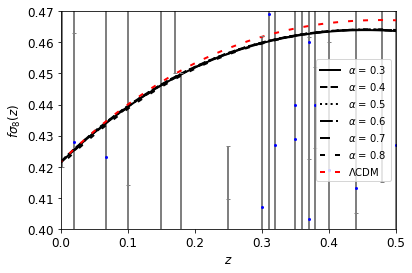

In [127]:
powers = [0.3,0.4,0.5,0.6,0.7,0.8]
delay = 6.5
linestyle = ['-', '--', ':','-.', (0, (5, 10)), (0, (2.5, 5))]
t_i = 21
tt = linspace(t_i,t_f, 2000)
alpha = 2/3
sigma8 = 0.811

plt.figure()
for i in range(len(powers)):
    
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
        
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (sigma8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)), linewidth =2,color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (0.811/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,0,0)), linewidth =2,color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

plt.tick_params(labelsize='large')
plt.legend(loc='best')    
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f\sigma_8(z)$',fontsize='large')
plt.show() 

plt.figure()
for i in range(len(powers)):
    
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
    
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (sigma8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)), linewidth =2,color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (0.811/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,0,0)), linewidth =2,color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

#plt.errorbar(fsigma8[:,0], fsigma8[:,1], yerr=fsigma8[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.ylim(0.15,0.7)
plt.xlim(0,3)
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f\sigma_8(z)$',fontsize='large')
plt.savefig('fsigma8_varalpha_close.pdf',bbox_inches='tight')
plt.show() 

plt.figure()
for i in range(len(powers)):
    
    a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
    
    plt.plot(a_b(tt[-1])/a_b(tt) -1, (sigma8/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,delay,0)), linewidth =2,color = 'black', ls = linestyle[i], label = r'$\alpha$ = '+str(powers[i]))
    if powers[i] == max(powers):
        a_b, a_m, d, d_p = growth_func(tt, delay, powers[i], 0)
        plt.plot(a_b(tt[-1])/a_b(tt) -1, (0.811/d(tt[-1]))*d_p(tt)*(a_b(tt)/background_derivative(a_b,tt,0,0)), linewidth =2,color = 'red', ls = linestyle[i], label = r'$\Lambda$CDM')

plt.errorbar(fsigma8[:,0], fsigma8[:,1], yerr=fsigma8[:,2], marker='.', markersize = 4, color = 'blue', ecolor='gray', elinewidth = 2, capsize = 2,ls='none')
plt.tick_params(labelsize='large')
plt.legend(loc='best')
plt.ylim(0.4,0.47)
plt.xlim(0.0,0.5)    
plt.xlabel('$z$',fontsize='large')
plt.ylabel('$f\sigma_8(z)$',fontsize='large')
plt.show() 

# IV. PyMultiNest

In [10]:
class DelayedCosmology_hubble(Solver):
    
    tau_min = 0
    tau_max = 20
    
    H0_min = 20
    H0_max = 100
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        tau_prime = cube[0]
        H0_prime = cube[1]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        
        return array([a,b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        
        if a < 0:
            return -10**3

        # calculate model
        z,pred1 = self._model(self._abscissa,a,b)
        noise1 = array(self._data) - array(pred1)
        sig1 = 1/array(self._sigma)
        chisq1 = -0.5*sum((noise1*sig1)**2)

        return chisq1
    
class DelayedCosmology_appmag(Solver):
    
    tau_min = 0
    tau_max = 20
    
    H0_min = 20
    H0_max = 100
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        tau_prime = cube[0]
        H0_prime = cube[1]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        
        return array([a,b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        
        if a < 0:
            return -10**3
        
        # calculate model
        z,pred1 = self._model(self._abscissa,a,b)
        noise1 = array(self._data) - array(pred1)
        sig1 = 1/array(self._sigma)
        chisq1 = -0.5*sum((noise1*sig1)**2)

        return chisq1
    
class DelayedCosmology_background(Solver):
    
    tau_min = 0
    tau_max = 20
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        tau_prime = cube[0]
        H0_prime = cube[1]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        
        return array([a,b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        
        if a < 0:
            return -10**3

        # calculate model
        pred1, pred2 = self._model(x,a,b)
        
        # Hubble expansion rate
        noise1 = array(self._data[0]) - array(pred1)
        sig1 = 1/array(self._sigma[0])
        chisq1 = -0.5*sum((noise1*sig1)**2)
        
        # Apparent magnitude
        noise2 = array(self._data[1]) - array(pred2)
        sig2 = 1/array(self._sigma[1])
        chisq2 = -0.5*sum((noise2*sig2)**2)

        return chisq1 + chisq2

class DelayedCosmology_f(Solver):
    
    tau_min = 0
    tau_max = 20
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):

        # extract values
        tau_prime = cube[0]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        
        return array([a])
    
    def LogLikelihood(self, cube):
        
        # extract parameters
        a = cube[0]
        
        if a < 0:
            return -10**3
        
        # calculate model
        pred1 = self._model(self._abscissa,a)

        noise1 = array(self._data) - array(pred1)
        sig1 = 1/array(self._sigma)
        chisq1 = -0.5*sum((noise1*sig1)**2)

        return chisq1
    
class DelayedCosmology_fsigma8(Solver):
    
    tau_min = 0
    tau_max = 20
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):

        # extract values
        tau_prime = cube[0]
        sigma8_prime = cube[1]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = sigma8_prime*(self.sigma8_max-self.sigma8_min) + self.sigma8_min
        
        return array([a,b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        
        if a < 0:
            return -10**3

        # calculate the model
        pred1 = self._model(x,a,b)

        
        # fsigma8
        noise1 = self._data - array(pred1)
        sig1 = 1/self._sigma
        chisq1 = -0.5*sum((noise1*sig1)**2)

        return chisq1
    
class DelayedCosmology_perturbation(Solver):
    
    tau_min = 0
    tau_max = 20
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        # set the data
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        tau_prime = cube[0]
        sigma8_prime = cube[1]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = sigma8_prime*(self.sigma8_max-self.sigma8_min) + self.sigma8_min
        
        return array([a, b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        
        if a < 0:
            return -10**3

        # calculate the model
        pred1, pred2 = self._model(x,a,b)

        # growth rate
        noise1 = array(self._data[0]) - array(pred1)
        sig1 = 1/array(self._sigma[0])
        chisq1 = -0.5*sum((noise1*sig1)**2)
        
        # fsigma8
        
        noise2 = array(self._data[1]) - array(pred2)
        sig2 = 1/array(self._sigma[1])
        chisq2 = -0.5*sum((noise2*sig2)**2)

        return chisq1 + chisq2
    
class DelayedCosmology_all(Solver):
    
    tau_min = 0
    tau_max = 20
    
    H0_min = 20
    H0_max = 100
    
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        tau_prime = cube[0]
        H0_prime = cube[1]
        sigma8_prime = cube[2]
        
        a = tau_prime*(self.tau_max-self.tau_min) + self.tau_min
        b = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        c = sigma8_prime*(self.sigma8_max-self.sigma8_min) + self.sigma8_min
        
        return array([a,b,c])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]
        c = cube[2]

        # calculate the model
        pred1, pred2, pred3 = self._model(x,a,b,c)
        
        # Hubble
        noise1 = array(self._data[0]) - array(pred1)
        sig1 = 1/array(self._sigma[0])
        chisq1 = -0.5*sum((noise1*sig1)**2)
        
        # Growth rate
        
        noise2 = array(self._data[1]) - array(pred2)
        sig2 = 1/array(self._sigma[1])
        chisq2 = -0.5*sum((noise2*sig2)**2)
        
        # fsigma8
        
        noise3 = array(self._data[2]) - array(pred3)
        sig3 = 1/array(self._sigma[2])
        chisq3 = -0.5*sum((noise3*sig3)**2)

        return chisq1 + chisq2 + chisq3
    
class LambdaCDM_hubble:
        
    H0_min = 20
    H0_max = 100
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        H0_prime = cube[0]
        
        a = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        
        return array([a])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        
        if a < 0:
            return -10**3

        # calculate model
        z,pred1 = self._model(self._abscissa,0,a)
        noise1 = array(self._data) - array(pred1)
        sig1 = 1/array(self._sigma)
        chisq1 = -0.5*sum((noise1*sig1)**2)

        return chisq1
    
    
class LambdaCDM_perturbation(Solver):
    
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        # set the data
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        sigma8_prime = cube[0]
        
        a = sigma8_prime*(self.sigma8_max-self.sigma8_min) + self.sigma8_min
        
        return array([a])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]

        # calculate the model
        pred1, pred2 = self._model(x,0,a)

        # growth rate
        noise1 = array(self._data[0]) - array(pred1)
        sig1 = 1/array(self._sigma[0])
        chisq1 = -0.5*sum((noise1*sig1)**2)
        
        # fsigma8
        
        noise2 = array(self._data[1]) - array(pred2)
        sig2 = 1/array(self._sigma[1])
        chisq2 = -0.5*sum((noise2*sig2)**2)

        return chisq1 + chisq2
    
class LambdaCDM_all(Solver):
    
    H0_min = 20
    H0_max = 100
    
    sigma8_min = 0.5
    sigma8_max = 0.9
    
    def __init__(self, data, abscissa, modelfunc, sigma, **kwargs):
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

        Solver.__init__(self, **kwargs)
        
    def Prior(self, cube):


        # extract values
        H0_prime = cube[0]
        sigma8_prime = cube[1]
        
        a = H0_prime*(self.H0_max-self.H0_min) + self.H0_min
        b = sigma8_prime*(self.sigma8_max-self.sigma8_min) + self.sigma8_min
        
        return array([a,b])
    
    def LogLikelihood(self, cube):

        # extract parameters
        a = cube[0]
        b = cube[1]

        # calculate the model
        pred1, pred2, pred3 = self._model(x,0,a,b)
        
        # Hubble
        noise1 = array(self._data[0]) - array(pred1)
        sig1 = 1/array(self._sigma[0])
        chisq1 = -0.5*sum((noise1*sig1)**2)
        
        # Growth rate
        
        noise2 = array(self._data[1]) - array(pred2)
        sig2 = 1/array(self._sigma[1])
        chisq2 = -0.5*sum((noise2*sig2)**2)
        
        # fsigma8
        
        noise3 = array(self._data[2]) - array(pred3)
        sig3 = 1/array(self._sigma[2])
        chisq3 = -0.5*sum((noise3*sig3)**2)

        return chisq1 + chisq2 + chisq3

In [11]:
nlive = 1024 # number of live points
tol = 0.1    # stopping criterion

## Delayed Hubble

In [17]:
ndim = 2 #number of parameters

# run the algorithm
t0 = time()
data = hubble[:,1]
x = hubble[:,0]
error = hubble[:,2]
delayed_hubble = DelayedCosmology_hubble(data, x, func_hubble, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol, verbose = True);
t1 = time()
timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpxlru6ferpymultinest/.txt
Time taken to run 'PyMultiNest' is 4495.23290014267 seconds


Removed no burn in


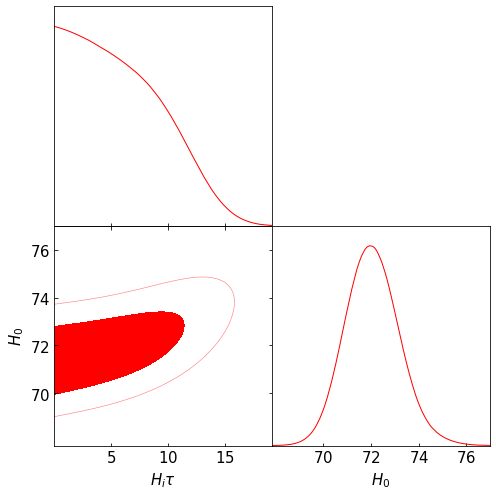

In [111]:
#achain_pymnest_hubble = delayed_hubble.samples[:,0] # extract chain of tau values
#bchain_pymnest_hubble = delayed_hubble.samples[:,1] # extract chain of H0 values
#samples_pymnest_hubble = vstack((achain_pymnest_hubble, bchain_pymnest_hubble)).T

# Save chains and evidence (do not forget)
#savetxt('pymultinest_hubble.csv', samples_pymnest_hubble, delimiter=",")
#savetxt('pymultinest_hubble_Z.csv', [delayed_hubble.logZ, delayed_hubble.logZerr])

samples_pymnest_hubble =  open_samples('samples/pymultinest_hubble.csv')

#corner.py
#fig = corner.corner(samples_pymnest_hubble, labels=[r"$H_i\tau$", "$H_0$"],color='blue', label_kwargs={"fontsize": 12},quantiles=[0.16, 0.5, 0.84],
#                      show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig('pymultinest_hubble.pdf')

#GetDist
samples_hubble = MCSamples(samples=samples_pymnest_hubble,names = ["x", "y"],ranges={"x":(0, None)}, labels = [r"H_i\tau", "H_0"])     
gdplots(samples_hubble, ["x", "y"],'pymultinest_hubble.pdf',15,15)

## Delayed growth rate 

In [13]:
ndim = 1 #number of parameters

# run the algorithm
t0 = time()
data = growth_rate[:,1]
x = growth_rate[:,0]
error = growth_rate[:,2]
delayed_f = DelayedCosmology_f(data, x, func_f, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol, verbose = True);
t1 = time()
timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpyh2656v7pymultinest/.txt
Time taken to run 'PyMultiNest' is 11523.63568520546 seconds


Removed no burn in


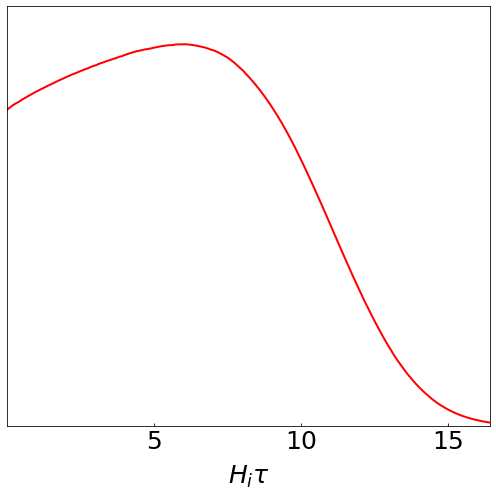

In [113]:
#achain_pymnest_f = delayed_f.samples[:,0] # extract chain of tau values
#samples_pymnest_f = vstack((achain_pymnest_f))

# Save chains and evidence (do not forget)
#savetxt('pymultinest_f.csv', samples_pymnest_f, delimiter=",")
#savetxt('pymultinest_f_Z.csv', [delayed_f.logZ, delayed_f.logZerr])

samples_pymnest_f =  open_samples('samples/pymultinest_f.csv')
#corner.py
#fig = corner.corner(samples_pymnest_f, labels=[r"$H_i\tau$"],color='blue', label_kwargs={"fontsize": 12},quantiles=[0.16, 0.5, 0.84],
#                       show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig('pymultinest_f.pdf')

#GetDist
samples_f = MCSamples(samples=samples_pymnest_f,names = ["x"],ranges={"x":(0, None)}, labels = [r"H_i\tau"])     
gdplots(samples_f, ["x"],'pymultinest_f.pdf',25,25)

## Delayed $f\sigma_8(z)$

In [34]:
ndim = 2 #number of parameters

t0 = time()

data = fsigma8[:,1]
x = fsigma8[:,0]
error = fsigma8[:,2]
delayed_fsigma8 = DelayedCosmology_fsigma8(data, x, func_fsigma8, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol, verbose = True);
t1 = time()
timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpde1lulo1pymultinest/.txt
Time taken to run 'PyMultiNest' is 8706.819159030914 seconds


Removed no burn in


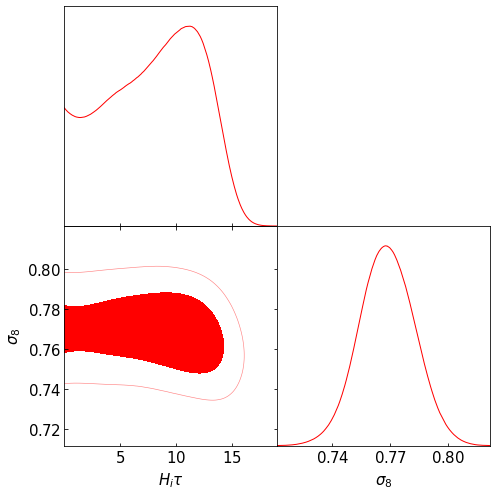

In [115]:
#achain_pymnest_fsigma8 = delayed_fsigma8.samples[:,0] # extract chain of tau values
#bchain_pymnest_fsigma8 = delayed_fsigma8.samples[:,1] # extract chain of sigma_8 values
#samples_pymnest_fsigma8 = vstack((achain_pymnest_fsigma8, bchain_pymnest_fsigma8)).T

# Save chains and evidence (do not forget)
#savetxt('pymultinest_fsigma8.csv', samples_pymnest_fsigma8, delimiter=",")
#savetxt('pymultinest_fsigma8_Z.csv', [delayed_fsigma8.logZ, delayed_fsigma8.logZerr])

samples_pymnest_fsigma8 = open_samples('samples/pymultinest_fsigma8.csv')
#corner.py
#fig = corner.corner(samples_pymnest_fsigma8, labels=[r"$H_i\tau$", r"$\sigma_8$"],color='blue', label_kwargs={"fontsize": 12},quantiles=[0.16, 0.5, 0.84],
#                       show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig('pymultinest_fsigma8.pdf')

#GetDist
samples_fsigma8 = MCSamples(samples=samples_pymnest_fsigma8,names = ["x", "y"],ranges={"x":(0, None)}, labels = [r"H_i\tau", "\sigma_8"])
gdplots(samples_fsigma8, ["x", "y"],'pymultinest_fsigma8.pdf',15,15)

## Delayed combined perturbation

In [39]:
ndim = 2 #number of parameters

t0 = time()

data = [growth_rate[:,1],fsigma8[:,1]]
x = [growth_rate[:,0],fsigma8[:,0]]
error = [growth_rate[:,2],fsigma8[:,2]]
delayed_perturbation = DelayedCosmology_perturbation(data, x, func_perturbation, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmp2juzflhepymultinest/.txt
Time taken to run 'PyMultiNest' is 11664.827560901642 seconds


Removed no burn in


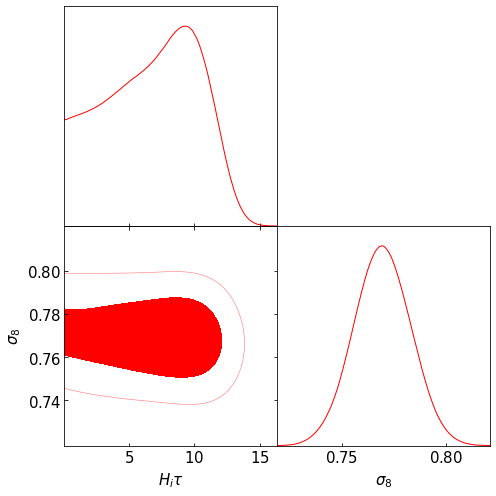

In [117]:
#achain_pymnest_perturbation = delayed_perturbation.samples[:,0] # extract chain of tau values
#bchain_pymnest_perturbation = delayed_perturbation.samples[:,1] # extract chain of sigma_8 values
#samples_pymnest_perturbation = vstack((achain_pymnest_perturbation, bchain_pymnest_perturbation)).T

# Save chains and evidence (do not forget)
#savetxt('pymultinest_perturbation.csv', samples_pymnest_perturbation, delimiter=",")
#savetxt('pymultinest_perturbation_Z.csv', [delayed_perturbation.logZ, delayed_perturbation.logZerr])

samples_pymnest_perturbation = open_samples('samples/pymultinest_perturbation.csv')

#corner.py
#fig = corner.corner(samples_pymnest_perturbation, labels=[r"$H_i\tau$", r"$\sigma_8$"],color='blue', label_kwargs={"fontsize": 12},quantiles=[0.16, 0.5, 0.84],
#                       show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig('pymultinest_perturbation.pdf')

#GetDist
samples_perturbation = MCSamples(samples=samples_pymnest_perturbation,names = ["x", "y"],ranges={"x":(0, None)}, labels = [r"H_i\tau", "\sigma_8"])        
gdplots(samples_perturbation, ["x", "y"],'pymultinest_perturbation.pdf', 15,15)

# Delayed all

In [12]:
ndim = 3 #number of parameters

t0 = time()

data = [hubble[:,1], growth_rate[:,1],fsigma8[:,1]]
x = [hubble[:,0],growth_rate[:,0],fsigma8[:,0]]
error = [hubble[:,2],growth_rate[:,2],fsigma8[:,2]]
delayed_all = DelayedCosmology_all(data, x, func_all, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpda02ygh9pymultinest/.txt
Time taken to run 'PyMultiNest' is 22609.55940413475 seconds


Removed no burn in


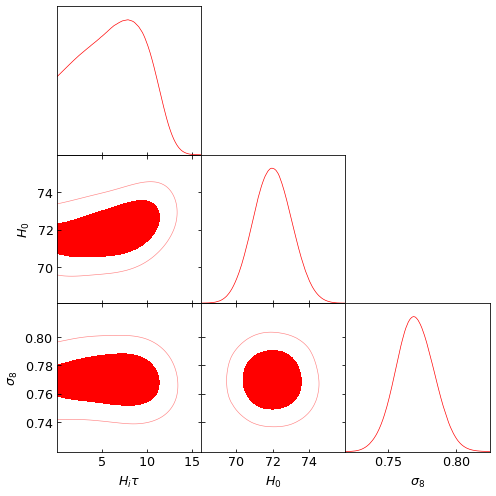

In [122]:
#achain_pymnest_delayed_all = delayed_all.samples[:,0] # extract chain of tau values
#bchain_pymnest_delayed_all = delayed_all.samples[:,1] # extract chain of H0 values
#cchain_pymnest_delayed_all = delayed_all.samples[:,2] # extract chain of sigma_8 values
#samples_pymnest_delayed_all = vstack((achain_pymnest_delayed_all, bchain_pymnest_delayed_all,cchain_pymnest_delayed_all)).T

# Save chains and evidence (do not forget)
#savetxt('pymultinest_delayed_all.csv', samples_pymnest_delayed_all, delimiter=",")
#savetxt('pymultinest_delayed_all_Z.csv', [delayed_all.logZ, delayed_all.logZerr])

samples_pymnest_delayed_all = open_samples('samples/pymultinest_delayed_all.csv')
#corner.py
#fig = corner.corner(samples_pymnest_delayed_all, labels=[r"$H_i\tau$", r"$H_0$", r"$\sigma_8$"],color='blue', label_kwargs={"fontsize": 12},quantiles=[0.16, 0.5, 0.84],
#                       show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig('pymultinest_delayed_all.pdf')

#GetDist
samples_perturbation = MCSamples(samples=samples_pymnest_delayed_all,names = ["x","y","z"],ranges={"x":(0, None)}, labels = [r"H_i\tau", "H_0", r"\sigma_8"])        
gdplots(samples_perturbation, ["x", "y","z"],'pymultinest_delayed_all.pdf', 15,15)

## $\Lambda$CDM Hubble

In [23]:
ndim = 1     # number of parameters

# run the algorithm
t0 = time()
data = hubble[:,1]
x = hubble[:,0]
error = hubble[:,2]
lcdm_hubble = LambdaCDM_hubble(data, x, func_hubble, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpz9kv6gntpymultinest/.txt
Time taken to run 'PyMultiNest' is 3620.7412140369415 seconds


In [24]:
print(lcdm_hubble)

print("")
print("log(Z) = {} ± {}".format(lcdm_hubble.logZ, lcdm_hubble.logZerr))


log(Z) = -13.011222631955674 ± 0.054264975303854615


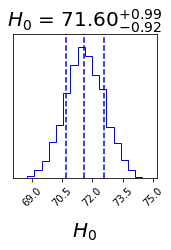

In [26]:
achain_pymnest_lcdm_hubble = lcdm_hubble.samples[:,0] # extract chain of H0 values
samples_pymnest_lcdm_hubble = vstack((achain_pymnest_lcdm_hubble))

# Save chains and evidence (do not forget)
savetxt('pymultinest_lcdm_hubble.csv', samples_pymnest_lcdm_hubble, delimiter=",")
savetxt('pymultinest_lcdm_hubble_Z.csv', [lcdm_hubble.logZ, lcdm_hubble.logZerr])

samples_pymnest_lcdm_hubble = open_samples('samples/pymultinest_lcdm_hubble.csv')

#corner.py
fig = corner.corner(samples_pymnest_lcdm_hubble, labels=[r"$H_0$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
#fig.savefig('pymultinest_lcdm_hubble.pdf')

## $\Lambda$CDM perturbation

In [43]:
ndim = 1     # number of parameters

# run the algorithm
t0 = time()
data = [growth_rate[:,1],fsigma8[:,1]]
x = [growth_rate[:,0],fsigma8[:,0]]
error = [growth_rate[:,2],fsigma8[:,2]]
lcdm = LambdaCDM(data, x, func_combined, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpavl8isbhpymultinest/.txt
Time taken to run 'PyMultiNest' is 5833.835636854172 seconds


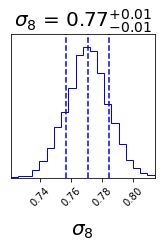

In [93]:
#achain_pymnest_lcdm = lcdm.samples[:,0] # extract chain of sigma_8 values
#samples_pymnest_lcdm = vstack((achain_pymnest_lcdm))

# Save chains and evidence (do not forget)
#savetxt('pymultinest_lcdm.csv', samples_pymnest_lcdm, delimiter=",")
#savetxt('pymultinest_lcdm_Z.csv', [lcdm.logZ, lcdm.logZerr])

samples_pymnest_lcdm = open_samples('samples/pymultinest_lcdm.csv')

#corner.py
fig = corner.corner(samples_pymnest_lcdm, labels=[r"$\sigma_8$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
#fig.savefig('pymultinest_lcdm.pdf')

## $\Lambda$CDM all

In [13]:
ndim = 2     # number of parameters

# run the algorithm
t0 = time()
data = [hubble[:,1],growth_rate[:,1],fsigma8[:,1]]
x = [hubble[:,0],growth_rate[:,0],fsigma8[:,0]]
error = [hubble[:,2],growth_rate[:,2],fsigma8[:,2]]
lcdm_all = LambdaCDM_all(data, x, func_all, error, n_dims=ndim,
                                        n_live_points=nlive, evidence_tolerance=tol);
t1 = time()

timepymultinest = (t1-t0)
print("Time taken to run 'PyMultiNest' is {} seconds".format(timepymultinest))

  analysing data from /var/folders/8y/nlgw1djs7tq5xqb6pw38yy_w0000gn/T/tmpk016c_q1pymultinest/.txt
Time taken to run 'PyMultiNest' is 14278.137708902359 seconds


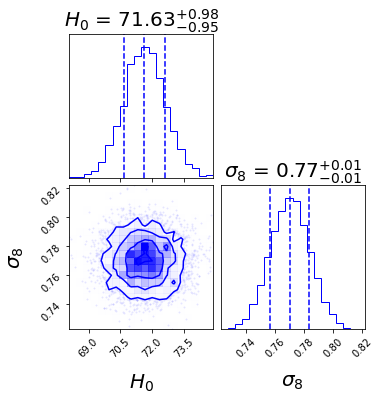

In [15]:
achain_pymnest_lcdm_all = lcdm_all.samples[:,0] # extract chain of H0 values
bchain_pymnest_lcdm_all = lcdm_all.samples[:,1] # extract chain of sigma_8 values
samples_pymnest_lcdm_all = vstack((achain_pymnest_lcdm_all, bchain_pymnest_lcdm_all)).T

# Save chains and evidence (do not forget)
savetxt('pymultinest_lcdm_all.csv', samples_pymnest_lcdm_all, delimiter=",")
savetxt('pymultinest_lcdm_all_Z.csv', [lcdm_all.logZ, lcdm_all.logZerr])

samples_pymnest_lcdm_all = open_samples('samples/pymultinest_lcdm_all.csv')

#corner.py
fig = corner.corner(samples_pymnest_lcdm_all, labels=["$H_0$",r"$\sigma_8$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
#fig.savefig('pymultinest_lcdm.pdf')

# V. Delay Estimates and Bayes Factors

In [132]:
#***Time Scale***

#Planck 2018
#H0 = 67.4 +/- 0.5
#Omega_Lambda = 0.6889 +/- 0.0056

OL_sqrt = sqrt(0.6889)
OL_sqrt_unc = 1/2*0.6889**(-1/2)*0.0056

H0 = asyd(67.4, 0.5, 0.5, N=10000, confidence=1.0)
OL = asyd(OL_sqrt, OL_sqrt_unc, OL_sqrt_unc, N=10000, confidence=1.0)

t_c = 1/(H0*0.001022*OL*sqrt(1e6))
print(t_c)

Value = 0.0175 (-0.0001, +0.0001) (1 sigma)
Value = 0.0175 (-0.0003, +0.0003) (2 sigma)
Value = 0.0175 (-0.0004, +0.0004) (3 sigma)


<Figure size 432x288 with 0 Axes>

In [133]:
#***Delay Estimates (PyMultiNest)***
#Note that values of the delays will be different per different runs of this cell
#because the final value of the delay is obtained by performing a Monte Carlo simulation via SOAD

tau_hubble = asyd(5.59, 3.86, 4.89, N=10000, confidence=1.0)*t_c
print(tau_hubble)
print("")

tau_f = asyd(6.10, 4.10, 4.04, N=10000, confidence=1.0)*t_c
print(tau_f)
print("")

tau_fsigma8 = asyd(8.58, 5.30, 4.04, N=10000, confidence=1.0)*t_c
print(tau_fsigma8)
print("")

tau_perturbation = asyd(7.26, 4.57, 3.35, N=10000, confidence=1.0)*t_c
print(tau_perturbation)
print("")

tau_all = asyd(6.49, 4.01, 3.52, N=10000, confidence=1.0)*t_c
print(tau_all)

Value = 0.0996 (-0.0655, +0.0826) (1 sigma)
Value = 0.0996 (-0.1188, +0.1900) (2 sigma)
Value = 0.0996 (-0.1629, +0.3353) (3 sigma)

Value = 0.1051 (-0.0700, +0.0709) (1 sigma)
Value = 0.1051 (-0.1390, +0.1429) (2 sigma)
Value = 0.1051 (-0.2070, +0.2158) (3 sigma)

Value = 0.1471 (-0.0926, +0.0714) (1 sigma)
Value = 0.1471 (-0.2176, +0.1280) (2 sigma)
Value = 0.1471 (-0.3955, +0.1741) (3 sigma)

Value = 0.1258 (-0.0796, +0.0590) (1 sigma)
Value = 0.1258 (-0.1928, +0.1045) (2 sigma)
Value = 0.1258 (-0.3666, +0.1406) (3 sigma)

Value = 0.1132 (-0.0699, +0.0616) (1 sigma)
Value = 0.1132 (-0.1498, +0.1164) (2 sigma)
Value = 0.1132 (-0.2422, +0.1653) (3 sigma)


<Figure size 432x288 with 0 Axes>

In [43]:
#***Bayes Factors***

z_lcdm_hubble = array(pd.read_csv('pymultinest_lcdm_hubble_Z.csv', header=None)).flatten()
z_lcdm_perturbation = array(pd.read_csv('pymultinest_lcdm_perturbation_Z.csv', header=None)).flatten()
z_lcdm_all = array(pd.read_csv('pymultinest_lcdm_all_Z.csv', header=None)).flatten()

z_delayed_hubble = array(pd.read_csv('pymultinest_hubble_Z.csv', header=None)).flatten()
z_delayed_perturbation = array(pd.read_csv('pymultinest_perturbation_Z.csv', header=None)).flatten()
z_delayed_all = array(pd.read_csv('pymultinest_delayed_all_Z.csv', header=None)).flatten()

#Background
print("ln B = {} +- {}".format(z_lcdm_hubble[0]-z_delayed_hubble[0], z_lcdm_hubble[1]+z_delayed_hubble[1]))
print("")

#Perturbation
print("ln B = {} +- {}".format(z_lcdm_perturbation[0]-z_delayed_perturbation[0], z_lcdm_perturbation[1]+z_delayed_perturbation[1]))
print("")

#Combined
print("ln B = {} +- {}".format(z_lcdm_all[0]-z_delayed_all[0], z_lcdm_all[1]+z_delayed_all[1]))


ln B = 0.44596403959016584 +- 0.11103704957618687

ln B = 0.10021202851262245 +- 0.09154858452260468

ln B = 0.1750832341184676 +- 0.14165324938080007
